In [1]:
import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt

In [ ]:
# (OPTIONAL) RUN THIS CELL TO UNZIP DATA FROM SITE

# CHANGE PATH TO WHERE YOU HAVE YOUR ZIP FILE LOCATED
path_to_zipfile = 'ADE20K_2017_05_30_consistency.zip'

# don't change this
directory_to_extract_to = './'
with zipfile.ZipFile(path_to_zipfile, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
# RUN THIS CELL TO LOAD DATA AND SORT INTO SAMPLES AND LABELS

# CHANGE PATH TO ROOT DIRECTORY OF WHERE YOUR DATA IS LOCATED
# e.g. ./projects/
dataloc = './'

# don't change this
datadir = dataloc + 'ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/'
imgkeys = [im.split('_seg')[0] for im in os.listdir(datadir) if '_seg' in im]
lblpaths = [datadir+im for im in os.listdir(datadir) if '_seg' in im]
imgpaths = [datadir+im for im in os.listdir(datadir) if '.jpg' in im and im.split('.jpg')[0] in imgkeys]


imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 64
Total # of labels = 64


(['./ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034.jpg',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001054.jpg'],
 ['./ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001001_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001005_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001015_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade20k/ADE_val_00001034_seg.png',
  './ADE20K_2017_05_30_consistency/images/consistencyanalysis/original_ade

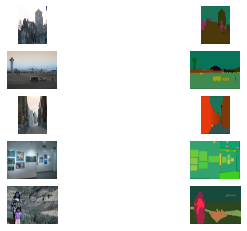

In [ ]:
# VIEW SAMPLES
fig, ax = plt.subplots(5,2)
for i in range(5):
    img = cv2.imread(imgpaths[i])
    lbl = cv2.imread(lblpaths[i]) 
    ax[i][0].imshow(img)
    ax[i][0].axis('off')
    ax[i][1].imshow(lbl)
    ax[i][1].axis('off')
plt.show()

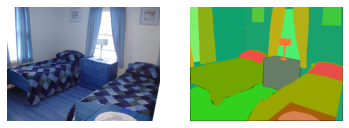

In [ ]:
# VIEW SAMPLES
fig, ax = plt.subplots(1,2)
img = cv2.imread(imgpaths[10])
lbl = cv2.imread(lblpaths[10]) 
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(lbl)
ax[1].axis('off')
plt.show()

In [ ]:
img.shape, lbl.shape

((1650, 2200, 3), (1500, 2000, 3))

In [ ]:
def load_images(dim, flatten_imgs=False):
    if flatten_imgs:
        X = np.array([cv2.resize(cv2.imread(imgpath), dim, interpolation=cv2.INTER_NEAREST).flatten().transpose() for imgpath in imgpaths])
        Y = np.array([cv2.resize(cv2.imread(lblpath), dim, interpolation=cv2.INTER_NEAREST).flatten().transpose() for lblpath in lblpaths])
    else:
        X = np.array([cv2.resize(cv2.imread(imgpath), dim, interpolation=cv2.INTER_NEAREST) for imgpath in imgpaths])
        Y = np.array([cv2.resize(cv2.imread(lblpath), dim, interpolation=cv2.INTER_NEAREST) for lblpath in lblpaths])
    return X,Y

In [ ]:
%%time
# change flatten_imgs to True or False depending on how you want to load the data
flatten_imgs = False
dim = (64,64) # set this to the dimensions you want the images to be, MUST BE SET b/c imgs have diff sizes
X, Y = load_images(dim, flatten_imgs)
print(X.shape, X[0].shape)

(64, 64, 64, 3) (64, 64, 3)
CPU times: user 2.32 s, sys: 25 ms, total: 2.35 s
Wall time: 2.36 s


# Labels Analysis
Here we examine what colors in the labelled segmentation images mean.

In [ ]:
colors_per_img = np.array([[-1,-1,-1]])
for img in Y:
    unique_colors_per_img = np.unique(img.reshape(-1, img[0].shape[1]), axis=0)
    colors_per_img = np.vstack((colors_per_img, unique_colors_per_img))

In [ ]:
# identify unique (R,G,B) 3-tuples
colors = np.unique(colors_per_img[1:,:], axis=0)

In [ ]:
print('Unique Colors in 64x64 images =', colors.shape[0])

Unique Colors in 64x64 images = 1355


In [ ]:
color_img = dict()

for color in colors:
    for img in Y:
        if color in img:
            ctup = (color[0], color[1], color[2])
            try:
                numimgs = color_img[ctup]
                color_img[ctup] = numimgs + 1
            except:
                color_img[ctup] = 1

In [ ]:
nonuniquelabels = 0
for c in color_img.keys():
    if color_img[c] > 1:
        nonuniquelabels += 1
print('Total colors = ', len(color_img))
print('Non-unique colors =', nonuniquelabels)

Total colors =  1355
Non-unique colors = 1355


# Re-Map Labels
We discovered in the analysis section that the segmentations are the colors corresponding to the labels, NOT labels themselves. This means that color labels are only relative to the image itself, not the dataset. For example, a tree in image 1 can be pink and a human in image 2 can be pink, but a tree in image 3 is not necessarily pink. We predict models might be performing a more unsupervised approach for dealing with this dataset.

The following attempt below is to map each color value in the segmentations to an integer label in order to simplify model training.

In [ ]:
# assign each color an int label
for i, c in zip(range(len(color_img)), color_img.keys()):
    color_img[c] = i

In [2]:
# FIX

for k in range(Y.shape[0]):
    lbl = Y[k]
    for j in range(lbl.shape[0]):
        dim1 = lbl[j]
        for i in range(dim1.shape[0]):
            color = dim1[i]
            ctup = (color[0], color[1], color[2])
            try:
                dim1[i] = color_img[ctup]
            except:
                print('Fail')
        lbl[j] = dim1
    Y[k] = lbl     

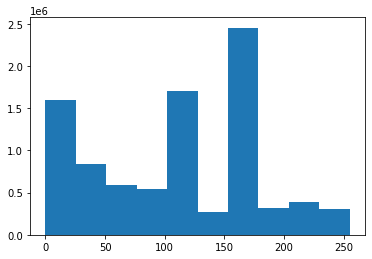

In [ ]:
# VIEW HISTOGRAM SHOWING TOTAL NUMBER OF CLASSES ON x-AXIS - corresponds to pixels
plt.hist(lbl.flatten())
plt.show()

In [ ]:
# Run proglearn RF or NN models